In [1]:
import os
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy
import csv
import gzip
import anndata as ad
from pathlib import Path
import glob
import scvi
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

-----
anndata     0.10.8
scanpy      1.10.3
-----
PIL                 10.4.0
absl                NA
asttokens           NA
attr                24.2.0
bottleneck          1.4.1
cffi                1.17.1
chex                0.1.87
comm                0.2.1
contextlib2         NA
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.6.7
decorator           5.1.1
distutils           3.12.7
docrep              0.3.2
etils               1.9.4
executing           0.8.3
filelock            3.16.1
flax                0.9.0
fsspec              2024.10.0
gmpy2               2.1.5
h5py                3.11.0
igraph              0.11.6
ipykernel           6.28.0
ipywidgets          8.1.3
jaraco              NA
jax                 0.4.34
jaxlib              0.4.34
jedi                0.18.1
joblib              1.4.2
kiwisolver          1.4.7
legacy_api_wrap     NA
leidenalg           0.10.2
lightning           2.4.0
lightning_utilities 0.11.7
llvmlit

In [2]:
directory = '/home/jing/Phd_project/project_GBM/gbm_DATA/gbm_DATA_GSE174554/gbm_DATA_scRNA_atlas'
os.chdir(directory)

In [3]:
outdir = '/home/jing/Phd_project/project_GBM/gbm_OUTPUT/gbm_OUTPUT_publication/'

In [4]:
names_list=['GSM5319518_SF2777','GSM5319548_SF2979','GSM5319519_SF2990',
                'GSM5319549_SF3073','GSM5319520_SF3076','GSM5319550_SF3243',
                'GSM5319521_SF3391','GSM5319551_SF3448','GSM5319511_SF11916',
                'GSM5319543_SF12382','GSM5319506_SF11082','GSM5319562_SF11488',
                'GSM5319530_SF9358','GSM5319568_SF9962','GSM5319559_SF9798','GSM5319532_SF9494']

In [5]:
adata_list = []

# Loop over each sample and read in the AnnData object
for name in names_list:

    mtx =f"{name}_matrix.mtx.gz"
    adata = sc.read_mtx(mtx)
    cells=pd.read_csv(f'{name}_barcodes.tsv.gz',header=None)
    features=pd.read_csv(f'{name}_features.tsv.gz',header=None,sep='\t')
    adata= adata.T
    #check the columns first to make sure they are the ones you need 
    adata.obs['CellID']= cells[0].tolist()
    adata.obs.index = adata.obs['CellID']
    adata.var['Gene']= features[0].tolist()
    adata.var.index= adata.var['Gene']
    adata.var_names_make_unique() 
    adata.var['mt'] =adata.var_names.str.startswith('MT-')


    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.calculate_qc_metrics(adata,qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    adata= adata[adata.obs.n_genes_by_counts <6000, :]
    adata= adata[adata.obs.pct_counts_mt< 5, :].copy()


    adata.obs['source'] = name[11:]
    adata.layers["counts"] = adata.X.copy()    
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata  # keep full dimension safe
    adata_list.append(adata)

normalizing counts per cell
    finished (0:00:00)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


In [6]:
batch_names = [adata.obs['source'].iloc[0] for adata in adata_list]
adata = adata_list[0].concatenate(adata_list[1:], batch_key='source', batch_categories=batch_names) 

/tmp/ipykernel_3467526/4058365435.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_list[0].concatenate(adata_list[1:], batch_key='source', batch_categories=batch_names)


In [7]:
adata.obs

,CellID,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,source
CellID,,,,,,,
AAACCCAAGGGATCAC-1-SF2777,AAACCCAAGGGATCAC-1,468,468,579.0,9.0,1.554404,SF2777
AAACCCAGTCGATTTG-1-SF2777,AAACCCAGTCGATTTG-1,311,311,402.0,4.0,0.995025,SF2777
AAACCCAGTCGTCAGC-1-SF2777,AAACCCAGTCGTCAGC-1,864,864,1518.0,3.0,0.197628,SF2777
AAACCCAGTTGTAAAG-1-SF2777,AAACCCAGTTGTAAAG-1,632,632,891.0,12.0,1.346801,SF2777
AAACCCATCTATCGGA-1-SF2777,AAACCCATCTATCGGA-1,849,849,1338.0,43.0,3.213752,SF2777
...,...,...,...,...,...,...,...
TTTGGTTTCATTATCC-1-SF9494,TTTGGTTTCATTATCC-1,2027,2027,4502.0,0.0,0.000000,SF9494
TTTGGTTTCCCTCGTA-1-SF9494,TTTGGTTTCCCTCGTA-1,1972,1972,4071.0,0.0,0.000000,SF9494
TTTGTTGTCAGACAAA-1-SF9494,TTTGTTGTCAGACAAA-1,2340,2340,5272.0,0.0,0.000000,SF9494


In [8]:
adata.obs['source'].value_counts()

source
SF3391     6798
SF3448     4555
SF11488    4458
SF2979     4278
SF2777     4183
SF11082    4134
SF9798     4051
SF9962     3468
SF9494     3454
SF3076     3214
SF3073     3153
SF9358     3147
SF3243     2545
SF12382    2056
SF2990     1890
SF11916    1332
Name: count, dtype: int64

In [9]:
adata

AnnData object with n_obs × n_vars = 56716 × 33694
    obs: 'CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source'
    var: 'Gene', 'mt', 'n_cells_by_counts-SF11082', 'mean_counts-SF11082', 'pct_dropout_by_counts-SF11082', 'total_counts-SF11082', 'n_cells_by_counts-SF11488', 'mean_counts-SF11488', 'pct_dropout_by_counts-SF11488', 'total_counts-SF11488', 'n_cells_by_counts-SF11916', 'mean_counts-SF11916', 'pct_dropout_by_counts-SF11916', 'total_counts-SF11916', 'n_cells_by_counts-SF12382', 'mean_counts-SF12382', 'pct_dropout_by_counts-SF12382', 'total_counts-SF12382', 'n_cells_by_counts-SF2777', 'mean_counts-SF2777', 'pct_dropout_by_counts-SF2777', 'total_counts-SF2777', 'n_cells_by_counts-SF2979', 'mean_counts-SF2979', 'pct_dropout_by_counts-SF2979', 'total_counts-SF2979', 'n_cells_by_counts-SF2990', 'mean_counts-SF2990', 'pct_dropout_by_counts-SF2990', 'total_counts-SF2990', 'n_cells_by_counts-SF3073', 'mean_counts-SF3073', 'pct_dropout_

In [10]:
adata.raw = adata  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="source",
    subset=True,
)

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [11]:
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="source")

In [12]:
model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")


In [13]:
model.train()


/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jing/miniforge3/envs/cstar/lib/python3.12/site ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jing/miniforge3/envs/cstar/lib/python3.12/site ...
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bo

Training:   0%|          | 0/141 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=141` reached.


In [14]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [15]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata,resolution=0.5)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)
running Leiden clustering


/tmp/ipykernel_3467526/3559472226.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata,resolution=0.5)


    finished: found 22 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:05)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:22)


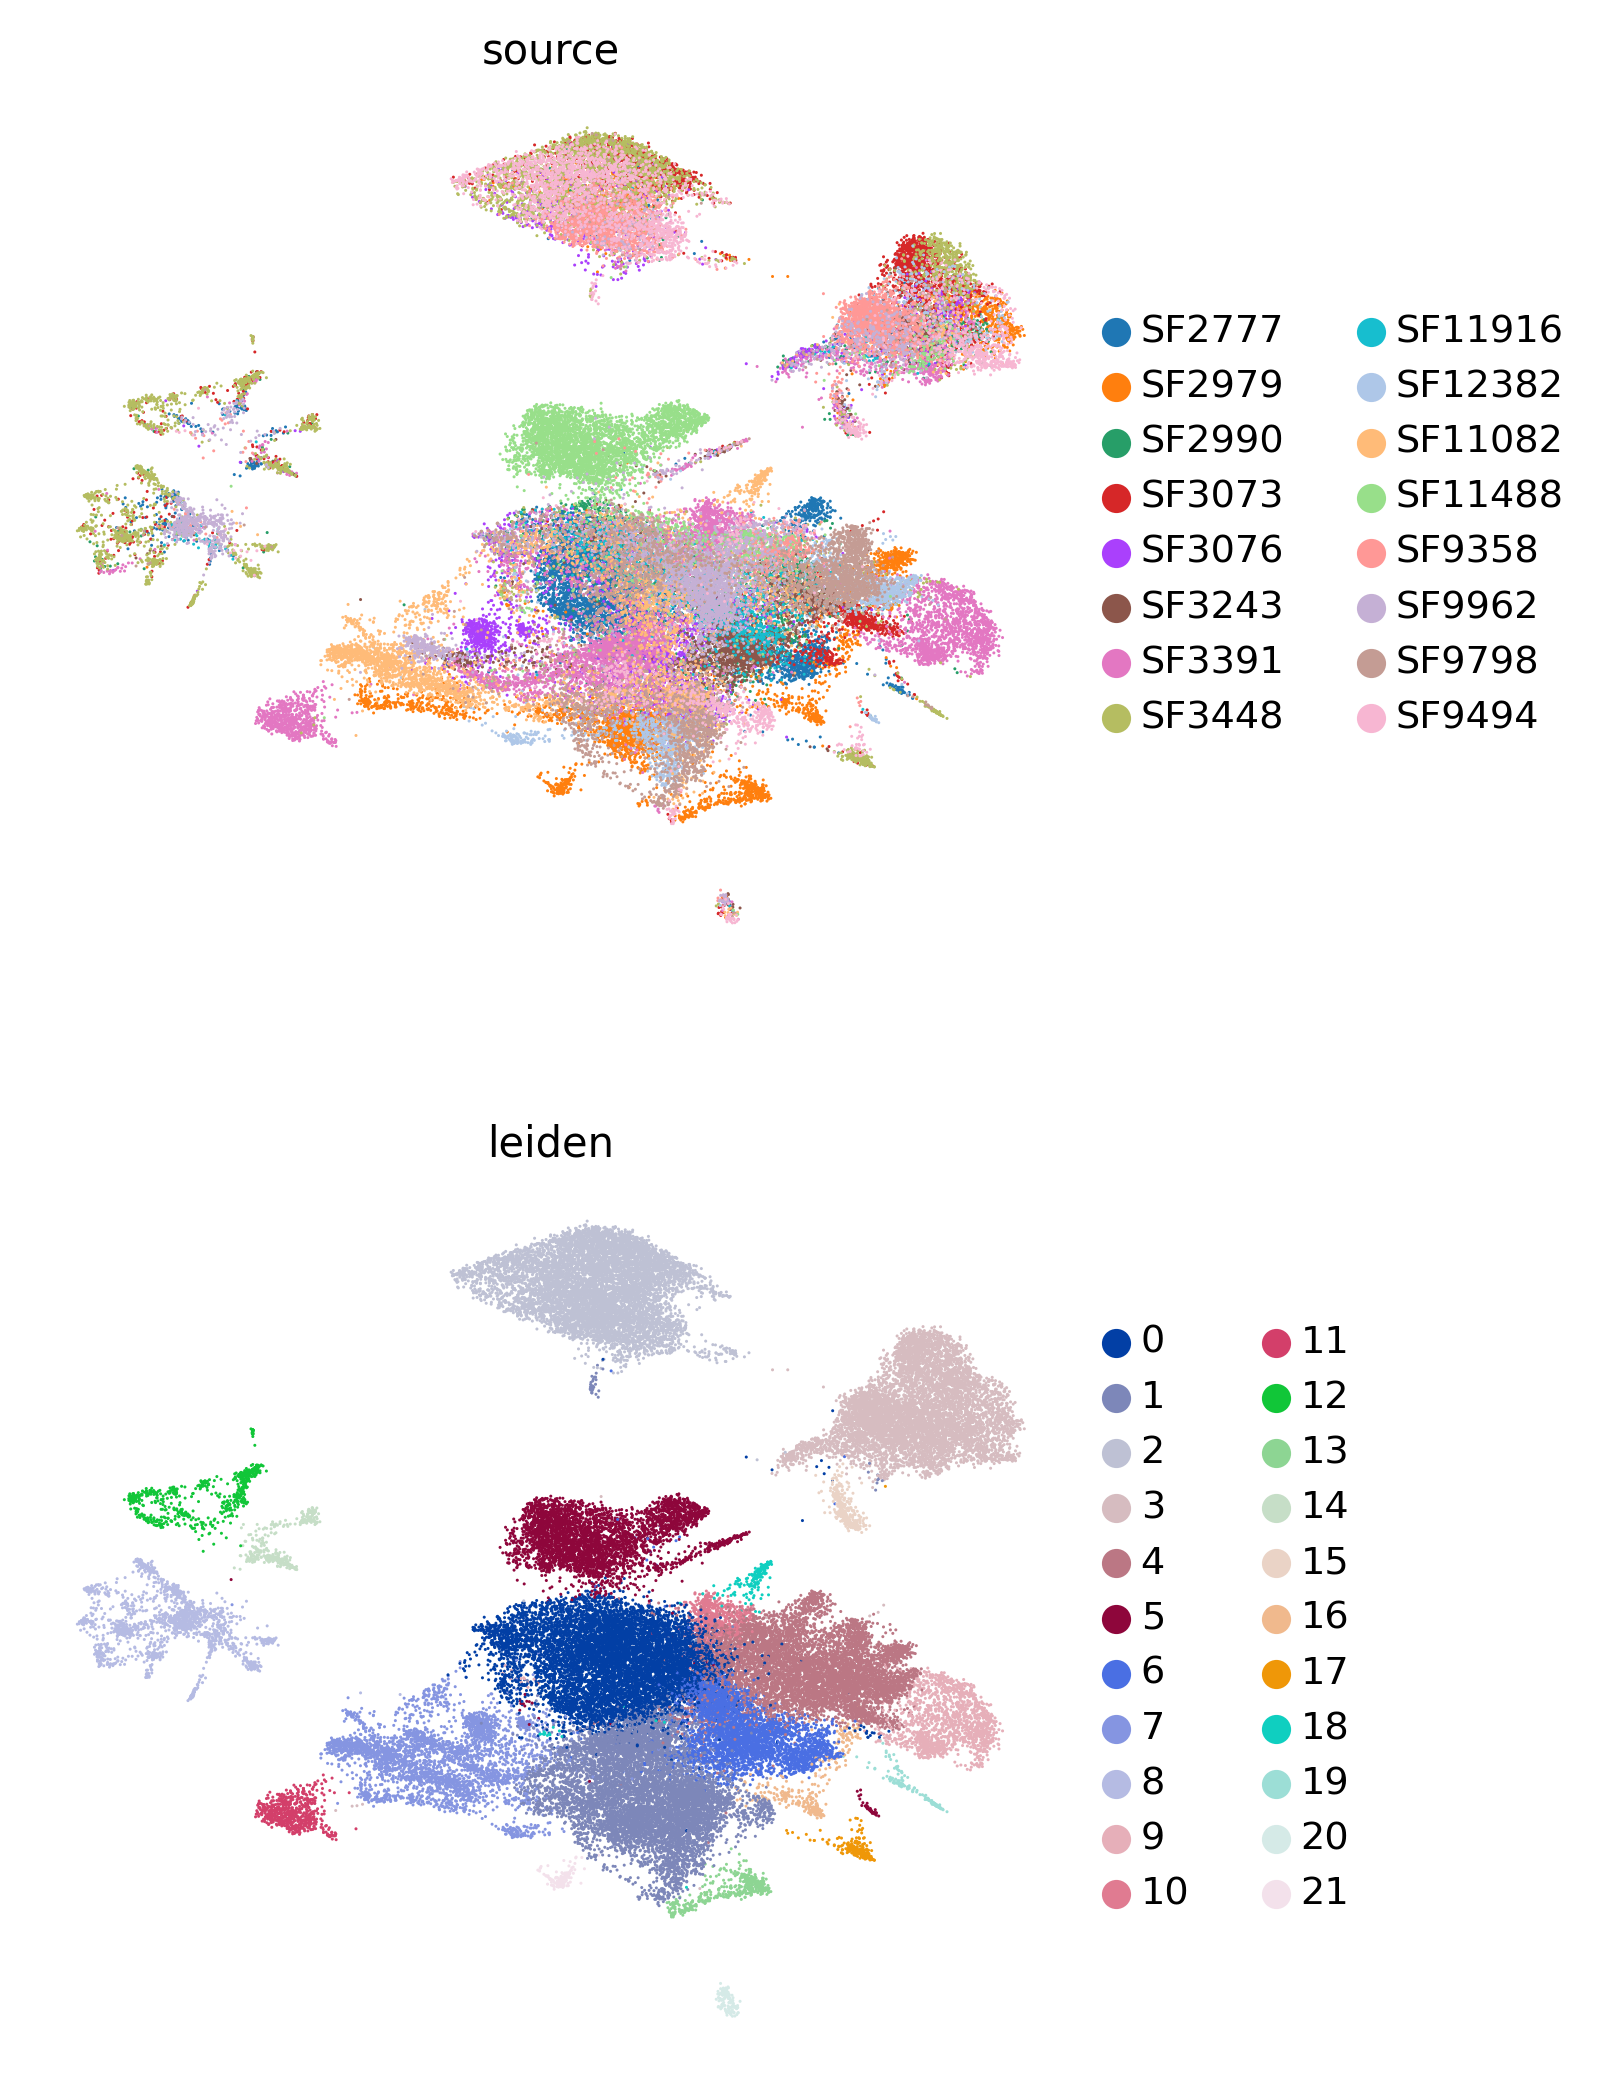

In [16]:
sc.tl.umap(adata, min_dist=0.5)
sc.pl.umap(
    adata,
    color=["source", "leiden"],
    frameon=False,
    ncols=1,
)

In [17]:
adata.obs['Status'] = 'Recurrent'
for i in ['SF2770', 'SF2990', 'SF3076', 'SF3391', 'SF11916', 'SF11082', 'SF9358', 'SF9798']:
    adata.obs.loc[adata.obs['source'].str.contains(i, na=False), 'Status'] = 'Primary'

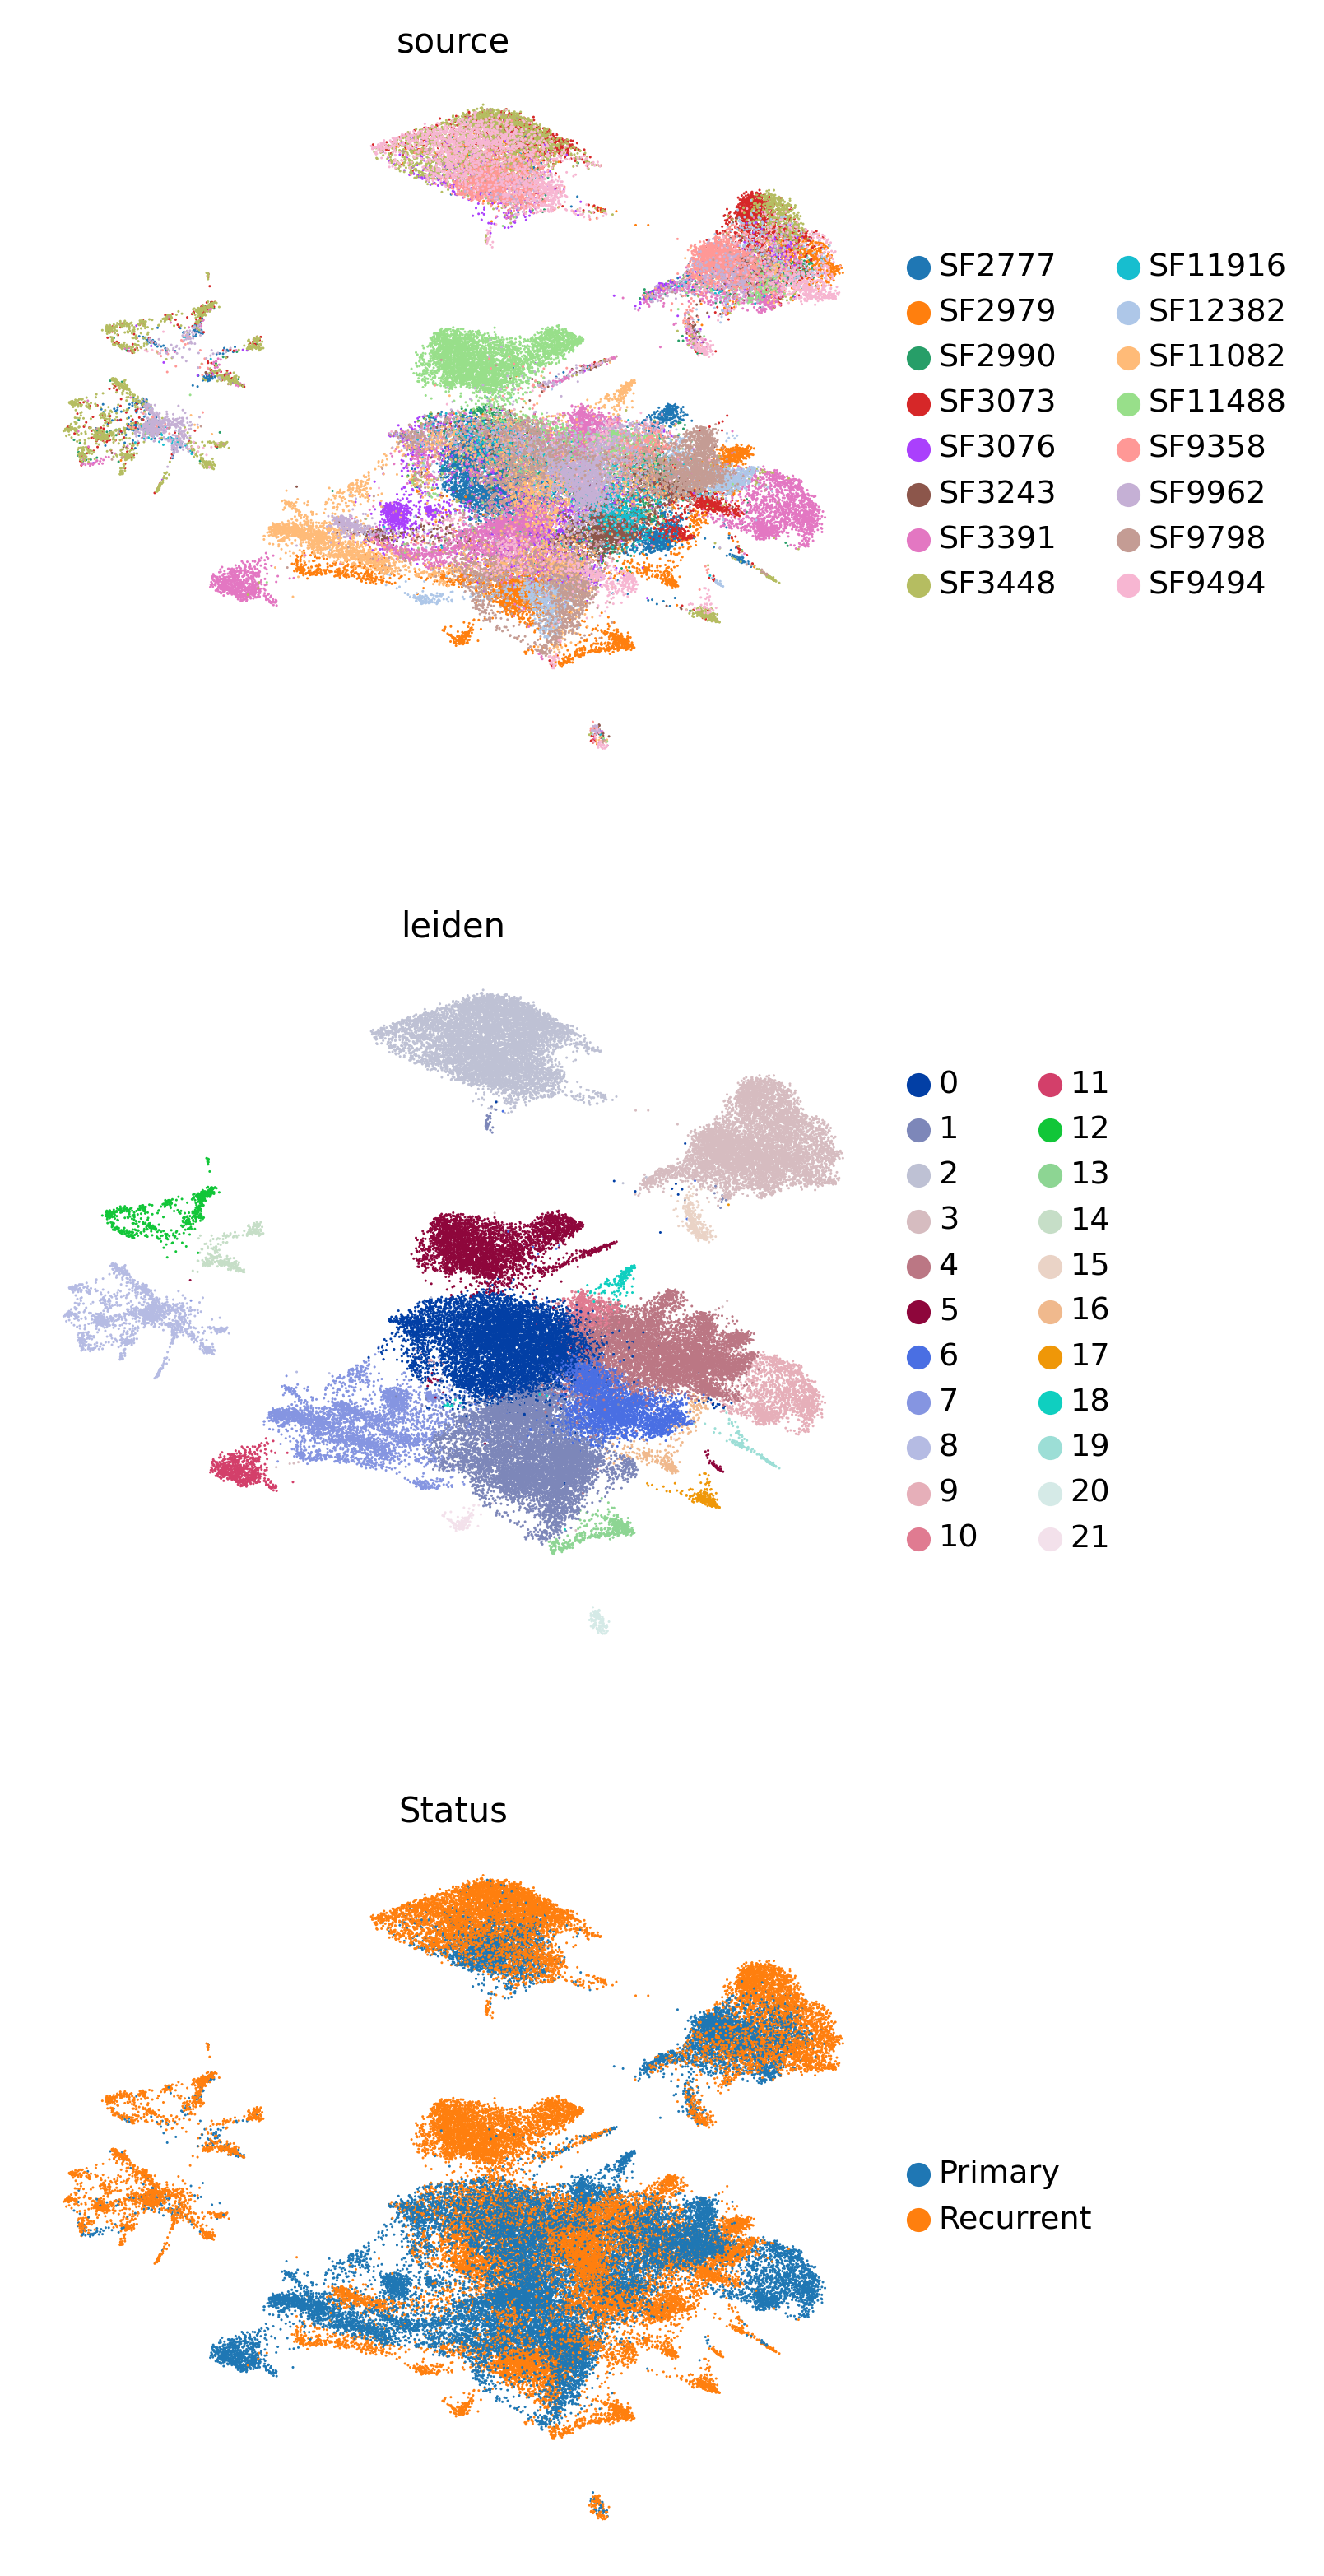

In [18]:
#sc.tl.umap(adata, min_dist=0.7)
sc.pl.umap(
    adata,
    color=["source", "leiden",'Status'],
    frameon=False,
    ncols=1,)

In [19]:
doublet_df = {}  

for i in set(adata.obs['source']):
    d = scvi.external.SOLO.from_scvi_model(model, restrict_to_batch=i)
    d.train()
    
    df_bulk = d.predict()
    
    df_bulk['solo_prediction'] = d.predict(soft=False)
    df_bulk.index = df_bulk.index.map(lambda x: x)
    
    doublet_df.update(dict(zip(df_bulk.index, df_bulk['solo_prediction'])))

INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jing/miniforge3/envs/cstar/lib/python3.12/site ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jing/miniforge3/envs/cstar/lib/python3.12/site ...
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bo

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.215. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intentio

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.336. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intentio

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.174. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intentio

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.200. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intentio

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.247. Signaling Trainer to stop.


/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jing/miniforge3/envs/cstar/lib/python3.12/site ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jing/miniforge3/envs/cstar/lib/python3.12/site ...
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bo

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.140. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intentio

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.163. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intentio

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.264. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intentio

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.202. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intentio

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.259. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intentio

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.235. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intentio

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.370. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intentio

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.318. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intentio

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.243. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intentio

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.188. Signaling Trainer to stop.
INFO     Creating doublets, preparing SOLO model.                                                                  


/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intentio

Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.248. Signaling Trainer to stop.


/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/torch/utils/_contextlib.py:116: UserWarning: Prior to scvi-tools 1.1.3, `SOLO.predict` with `soft=True` (the default option) returned logits instead of probabilities. This behavior has since been corrected to return probabiltiies. The previous behavior can be replicated by passing in `return_logits=True`.
  return func(*args, **kwargs)


In [20]:
df_output = pd.DataFrame(list(doublet_df.items()), columns=['Index', 'Solo_Prediction'])
df_output.to_csv(os.path.join(outdir,'doublet_predictions.csv'), index=False)

In [21]:
df_output

,Index,Solo_Prediction
0,AAACCCAAGCGAACTG-1-SF9494,doublet
1,AAACCCAAGGCATTTC-1-SF9494,singlet
2,AAACCCAAGTACCGGA-1-SF9494,doublet
3,AAACCCATCATTCGGA-1-SF9494,singlet
4,AAACCCATCCTCTCGA-1-SF9494,singlet
...,...,...
56711,TTTGTTGAGTACCATC-1-SF2777,singlet
56712,TTTGTTGCACTGGCCA-1-SF2777,doublet
56713,TTTGTTGGTACTCAAC-1-SF2777,doublet
56714,TTTGTTGTCCCAAGTA-1-SF2777,doublet
